In [7]:
import numpy as np
from scipy.linalg import inv, eigvals, norm
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm

from utils import *
from models import TimeVaryingSEM

In [8]:
def generate_random_S(N, sparsity=0.2, max_weight=0.5, seed=None):
    """
    Generates a random symmetric sparse matrix S with given sparsity and maximum weight.
    Ensures that the spectral radius of S is less than 1 for stability.
    
    Parameters:
    - N: Number of nodes.
    - sparsity: Probability of an edge existing between any two nodes.
    - max_weight: Maximum absolute weight for any edge.
    - seed: Random seed for reproducibility.
    
    Returns:
    - S: Generated symmetric sparse matrix of shape (N, N).
    """
    if seed is not None:
        np.random.seed(seed)
    
    S = np.zeros((N, N))
    
    for i in range(N):
        for j in range(i + 1, N):  # 上三角部分のみを設定
            if np.random.rand() < sparsity:
                weight = np.random.uniform(0, max_weight)
                S[i, j] = weight
                S[j, i] = weight  # 対称性を保つために反対側も同じ値に設定
    
    # Ensure spectral radius < 1
    spectral_radius = max(abs(eigvals(S)))
    if spectral_radius >= 1:
        S = S / (spectral_radius + 0.1)  # Scale down to ensure stability
    
    return S

def modify_S(S, edge_indices, factor=2.0):
    """
    Modifies the matrix S by multiplying specified edges by a given factor.
    
    Parameters:
    - S: Original matrix of shape (N, N).
    - edge_indices: List of tuples indicating which edges to modify.
    - factor: Multiplicative factor for the specified edges.
    
    Returns:
    - S_modified: Modified matrix.
    """
    S_modified = S.copy()
    for (i, j) in edge_indices:
        if i != j:
            S_modified[i, j] *= factor
            S_modified[j, i] *= factor  # Ensure symmetry
    return S_modified

def generate_stationary_X(N, T, sparsity=0.2, max_weight=0.5, std_e=np.sqrt(0.5), seed=None):
    S = generate_random_S(N, sparsity=sparsity, max_weight=max_weight, seed=seed)
    S_series = [S for _ in range(T)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S = inv(I - S)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X = inv_I_S @ e_t_series

    return S_series, X

def generate_piecewise_X(N, T, change_time, change_indices, sparsity=0.2, max_weight=0.5, std_e=np.sqrt(0.5), seed=None):
    pass

def solve_offline_sem(X_up_to_t, lambda_reg):
    """
    Solves the SEM optimization problem offline using CVXPY.
    
    Parameters:
    - X_up_to_t: Data matrix up to time t, shape (N, t).
    - lambda_reg: Regularization parameter lambda.
    
    Returns:
    - S_opt: Optimal S matrix from CVXPY, shape (N, N).
    """
    N, t = X_up_to_t.shape
    S = cp.Variable((N, N), symmetric=True)
    
    # Objective: (1/(2t)) ||X - S X||_F^2 + lambda * ||S||_1
    objective = (1/(2*t)) * cp.norm(X_up_to_t - S @ X_up_to_t, 'fro') + lambda_reg * cp.norm1(S)
    
    # Constraints: S is hollow (zero diagonal)
    constraints = [cp.diag(S) == 0]
    
    # Define problem
    prob = cp.Problem(cp.Minimize(objective), constraints)
    
    # Solve problem
    prob.solve(solver=cp.SCS, verbose=False)
    
    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError("CVXPY did not find an optimal solution.")
    
    S_opt = S.value
    return S_opt



Loaded cached matrix from matrix_cache/duplication_matrix_hh_N=10.npz
Loaded cached matrix from matrix_cache/elimination_matrix_hh_N=10.npz


100%|██████████| 500/500 [00:16<00:00, 31.16it/s]


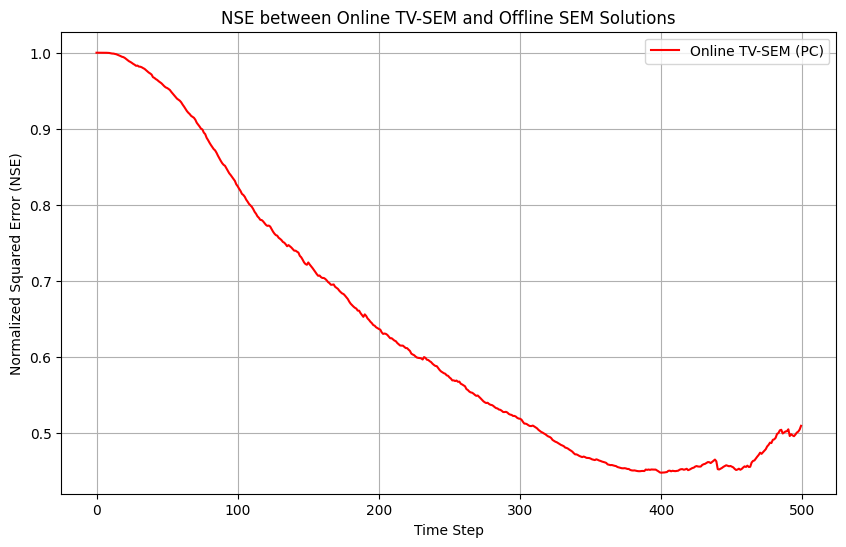

In [9]:
# Simulation parameters
N = 10          # Number of nodes
T = 500      # Number of time steps for simulation (adjust as needed)
sparsity = 0.2  # Initial sparsity
max_weight = 0.4
change_time = T // 2
# Define edges to modify: list of tuples (i, j)
# For example, modify edges between node 0 and 1, and node 2 and 3
# change_indices = [(0, 1), (2, 3), (4, 5)]
variance_e = 0.5
std_e = np.sqrt(variance_e)
seed = 42  # For reproducibility
# TV-SEM Simulation
S_series, X = generate_stationary_X(N=N, T=T, sparsity=sparsity, max_weight=max_weight,
                                    std_e=std_e, seed=seed)
# Online TV-SEM Parameters
P = 1  # Number of prediction steps
C = 1  # Number of correction steps
lambda_reg = 0.005  # Regularization parameter
gamma = 0.999  # Forgetting factor for empirical covariance
alpha = 0.01  # Step size for prediction
beta = 0.01   # Step size for correction

tv_sem = TimeVaryingSEM(N, lambda_reg, alpha, beta, gamma, P, C)
estimates = tv_sem.run(X)

NSE = []
for i, estimate in enumerate(tqdm((estimates))):
    S_opt = solve_offline_sem(X[:, :i+1], lambda_reg)
    # NSE.append(norm(estimate - S_series[0]) / norm(S_series[0]))
    NSE.append(norm(estimate - S_opt) / norm(S_opt))


# Plot NSE over time
plt.figure(figsize=(10,6))
plt.plot(NSE, label='Online TV-SEM (PC)', color='red')
plt.xlabel('Time Step')
plt.ylabel('Normalized Squared Error (NSE)')
plt.title('NSE between Online TV-SEM and Offline SEM Solutions')
plt.legend()
plt.grid(True)
plt.show()
